In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  


In [2]:
data_folder = './results'

## Portfolio problem

In [3]:
task_name = 'portfolio'
data_list =  ['syn_1000_800_10_50', 'syn_1000_1200_10_50', 'syn_1000_1500_10_50',
              'syn_1000_800_10_50_1', 'syn_1000_1200_10_50_1', 'syn_1000_1500_10_50_1',
              'syn_1000_800_10_50_2', 'syn_1000_1200_10_50_2', 'syn_1000_1500_10_50_2',
              'syn_1000_800_10_50_3', 'syn_1000_1200_10_50_3', 'syn_1000_1500_10_50_3']
data_defs =  ['syn_1000_800_10_50', 'syn_1000_1200_10_50', 'syn_1000_1500_10_50']
policy_list = run_alpha_policies = ["standard","line_search","icml","backtracking","new_lloo","scopt"]
policy_labels=['Standard','Line Search','Ver1','Ver2','LLOO','PN']
results = dict()

#for data_name in data_list:
#    file_path = os.path.join(data_folder, task_name, data_name + '.pckl')
#    with open(file_path, 'rb') as f:
#        results[data_name] = pickle.load(f)

In [4]:
f_optim_values, error_hist_data, time_hist_data = {}, {}, {}

# calculate relative errors and save it (with time data)
for data_name in data_list:
    file_path = os.path.join(data_folder, task_name, data_name + '.pckl')
    with open(file_path, 'rb') as f:
        data_results =  pickle.load(f)
    data_results = data_results[data_name]
    f_min = min([data_results[policy]['Q_hist'][-1] for policy in data_results.keys()])
    f_optim_values[data_name] = f_min
    for policy in data_results.keys():
        errors = [abs(f_val - f_min) / abs(f_min) for f_val in data_results[policy]['Q_hist']]
        if policy not in error_hist_data.keys():
            error_hist_data[policy] = {}
            time_hist_data[policy] = {}
        error_hist_data[policy][data_name] = np.array(errors)
        time_hist_data[policy][data_name] = np.array(data_results[policy]['time_hist'])

## Print problem info

In [12]:
error_thr = 1e-5

for i in range(len(policy_list)):
    policy = policy_list[i]
    policy_label = policy_labels[i]
    for data_label in data_defs:
        error_hists = [np.array(error_hist_data[policy][data_name]) for data_name in data_list if data_label in data_name]
        time_hists = [np.array(time_hist_data[policy][data_name]) for data_name in data_list if data_label in data_name]
        min_iters_qty = [np.argmax(hist < error_thr) if any(hist < error_thr) else len(hist)-1 for hist in error_hists]
        min_time_qty = [sum(hist[:min_iter]) for min_iter, hist in zip(min_iters_qty, time_hists)]
        errors = [hist[iter] for iter, hist in zip(min_iters_qty, error_hists)]
        avg_error = np.mean(errors)
        avg_iter = np.mean(min_iters_qty)
        avg_time = np.mean(min_time_qty)

        print(policy_label)
        print(data_label)
        print(f'Avg error: {avg_error:.2e}')
        print(f'Avg iter qty: {avg_iter:.2f}')
        print(f'Avg time qty: {avg_time:.2f}')

Standard
syn_1000_800_10_50
Avg error: 9.42e-06
Avg iter qty: 459.50
Avg time qty: 1.08
Standard
syn_1000_1200_10_50
Avg error: 9.84e-06
Avg iter qty: 448.50
Avg time qty: 1.62
Standard
syn_1000_1500_10_50
Avg error: 9.82e-06
Avg iter qty: 475.50
Avg time qty: 2.11
Line Search
syn_1000_800_10_50
Avg error: 8.14e-06
Avg iter qty: 17.75
Avg time qty: 0.14
Line Search
syn_1000_1200_10_50
Avg error: 8.54e-06
Avg iter qty: 12.75
Avg time qty: 0.18
Line Search
syn_1000_1500_10_50
Avg error: 8.69e-06
Avg iter qty: 13.00
Avg time qty: 0.23
Ver1
syn_1000_800_10_50
Avg error: 1.00e-05
Avg iter qty: 21675.00
Avg time qty: 55.39
Ver1
syn_1000_1200_10_50
Avg error: 9.79e-06
Avg iter qty: 13379.75
Avg time qty: 55.83
Ver1
syn_1000_1500_10_50
Avg error: 1.00e-05
Avg iter qty: 21070.75
Avg time qty: 105.80
Ver2
syn_1000_800_10_50
Avg error: 5.51e-05
Avg iter qty: 50000.00
Avg time qty: 147.92
Ver2
syn_1000_1200_10_50
Avg error: 3.69e-05
Avg iter qty: 50000.00
Avg time qty: 215.88
Ver2
syn_1000_1500_10

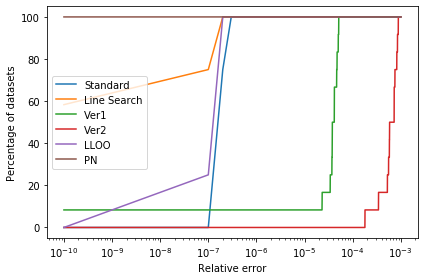

In [15]:
#dataset percentage plot
policy_percentage_plot = {}
for i in range(len(policy_list)):
    policy = policy_list[i]
    policy_label = policy_labels[i]
    error_range = np.arange(1e-10, 1e-3, 1e-7)
    achieved_error_data_qty = []
    for error_val in error_range:
        curr_error_achieved_qty = 0
        for error_hist in error_hist_data[policy].values():
            if (len(error_hist) < 10000) or (error_hist[5000] < error_val):
                curr_error_achieved_qty += 1
        achieved_error_data_qty.append(curr_error_achieved_qty)
    policy_percentage_plot[policy] = achieved_error_data_qty
for i in range(len(policy_percentage_plot)):
    policy = policy_list[i]
    policy_label = policy_labels[i]
    plt.plot(error_range, np.array(policy_percentage_plot[policy]) / len(data_list) * 100, label=policy_label)

plt.legend()
plt.xscale('log')
plt.xlabel('Relative error')
plt.ylabel(('Percentage of datasets'))
plt.tight_layout()
plt.savefig('./pics/dataset_proportion_plot.png')
plt.show()

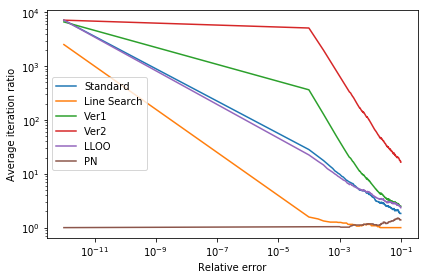

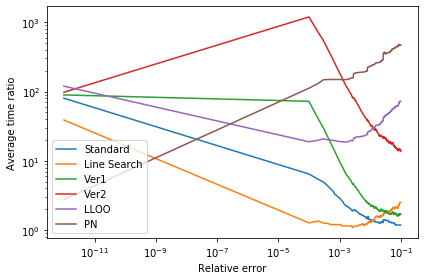

In [17]:
#average ratio iter plot
minimal_iter_per_algo = {}
minimal_time_per_algo = {}

for policy in error_hist_data.keys():
    error_range = np.arange(1e-12, 1e-1, 1e-4)
    for data_name, error_hist in error_hist_data[policy].items():
        current_data_minimal_iters = []
        current_data_minimal_times = []
        for error_val in error_range:
            if any(error_hist < error_val):
                # find index of first error that lower than threshold (+1 since numeration starts from 0)
                iter_index = np.argmax(error_hist < error_val) + 1
                current_data_minimal_iters.append(iter_index)
                current_data_minimal_times.append(np.sum(time_hist_data[policy][data_name][:iter_index]))
            else:
                current_data_minimal_iters.append(len(error_hist))
                current_data_minimal_times.append(np.sum(time_hist_data[policy][data_name]))
        if policy not in minimal_iter_per_algo.keys():
            minimal_iter_per_algo[policy] = {}
            minimal_time_per_algo[policy] = {}
        minimal_iter_per_algo[policy][data_name] = current_data_minimal_iters
        minimal_time_per_algo[policy][data_name] = current_data_minimal_times

ratio_of_iter_per_algo = {}
ratio_of_time_per_algo = {}

for data_name in data_list:
    for i in range(len(error_range)):
        iters_over_policies = [minimal_iter_per_algo[policy][data_name][i] for policy in policy_list]
        times_over_policies = [minimal_time_per_algo[policy][data_name][i] for policy in policy_list]
        minimal_iter_val = min(iters_over_policies)
        minimal_time_val = min(times_over_policies)
        for policy in policy_list:
            if policy not in ratio_of_iter_per_algo.keys():
                ratio_of_iter_per_algo[policy] = {}
                ratio_of_time_per_algo[policy] = {}
            if data_name not in ratio_of_iter_per_algo[policy].keys():
                ratio_of_iter_per_algo[policy][data_name] = []
                ratio_of_time_per_algo[policy][data_name] = []
            ratio_of_iter_per_algo[policy][data_name].append(minimal_iter_per_algo[policy][data_name][i] / minimal_iter_val)
            ratio_of_time_per_algo[policy][data_name].append(minimal_time_per_algo[policy][data_name][i] / minimal_time_val)

for j in range(len(policy_list)):
    policy = policy_list[j]
    policy_label = policy_labels[j]
    policy_avg_ratios = []
    for i in range(len(error_range)):
        policy_avg_ratios.append(np.mean([ratio_of_iter_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_ratios, label=policy_label)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative error')
plt.ylabel('Average iteration ratio')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/avg_iter_plot.png')
plt.show()

for j in range(len(policy_list)):
    policy = policy_list[j]
    policy_label = policy_labels[j]
    policy_avg_time_ratios = []
    for i in range(len(error_range)):
        policy_avg_time_ratios.append(np.mean([ratio_of_time_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_time_ratios, label=policy_label)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Relative error')
plt.ylabel('Average time ratio')
plt.legend()
plt.tight_layout()
plt.savefig('./pics/avg_time_plot.png')
plt.show()

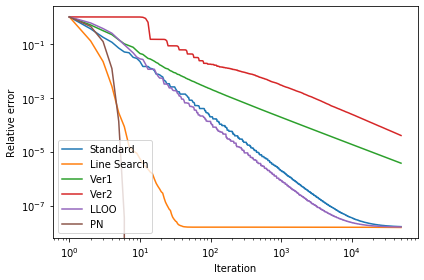

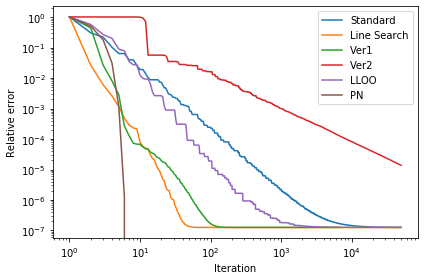

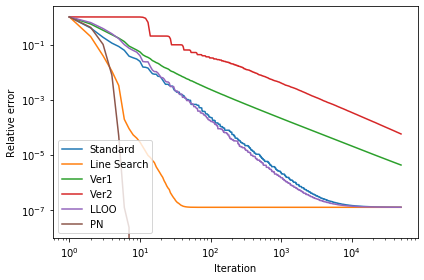

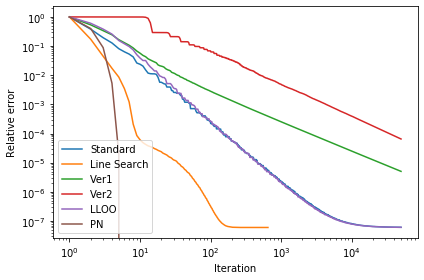

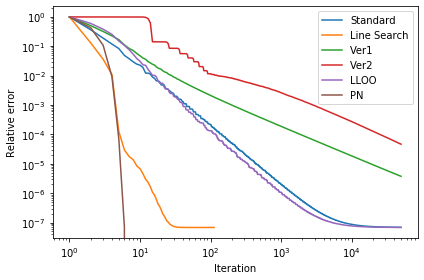

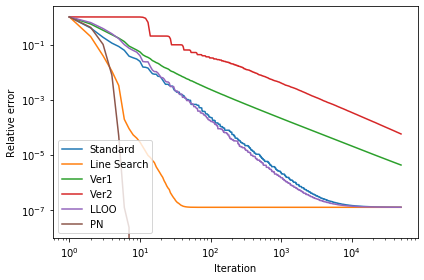

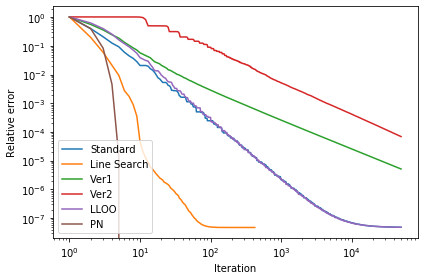

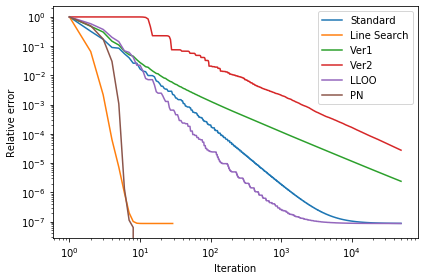

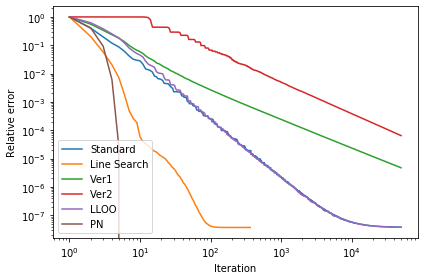

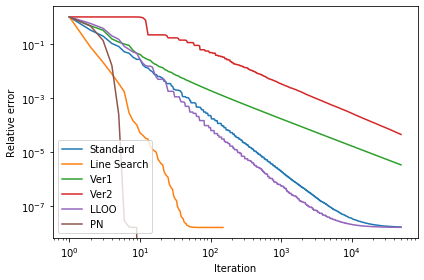

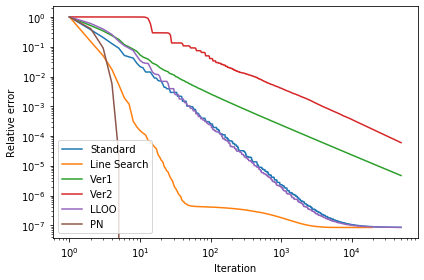

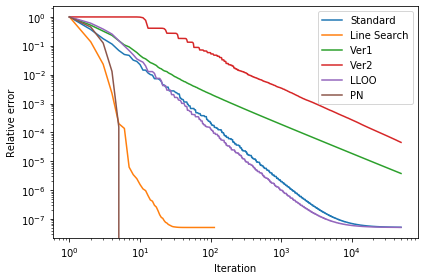

In [22]:
for data in data_list:
    for i in range(len(policy_list)):
        policy=policy_list[i]
        policy_label=policy_labels[i]
        series = pd.Series(error_hist_data[policy][data]) 
        plt.plot(range(1,len(error_hist_data[policy][data])+1),series.cummin(), label=policy_label)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Relative error')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join('./pics', data + '_iter.png'))
    plt.show()

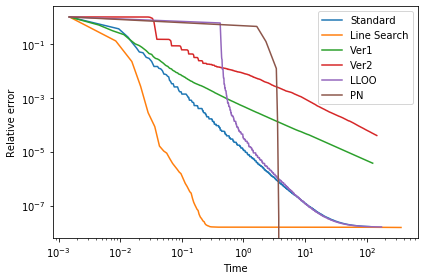

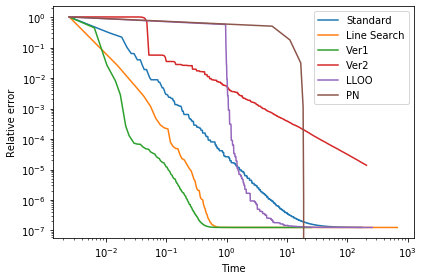

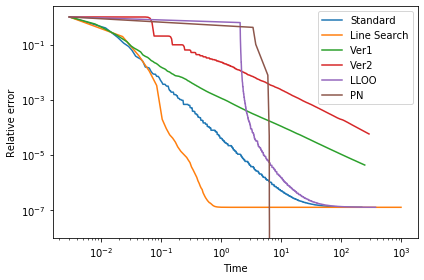

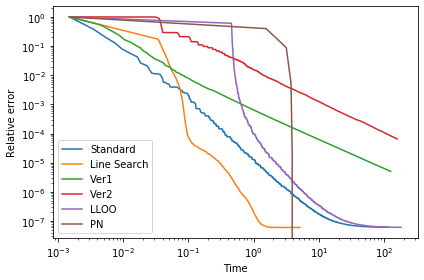

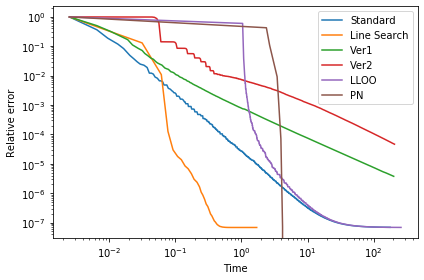

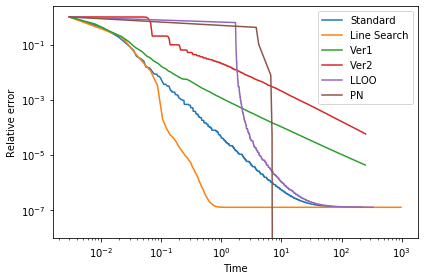

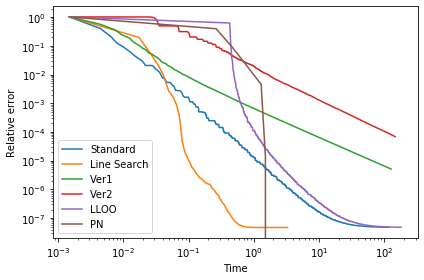

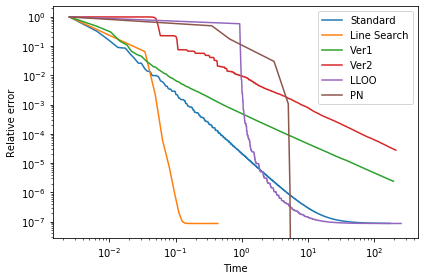

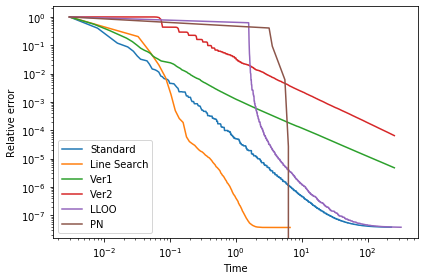

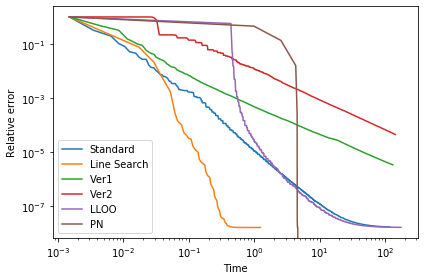

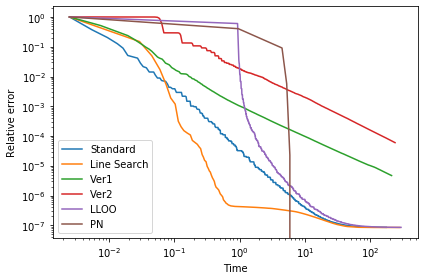

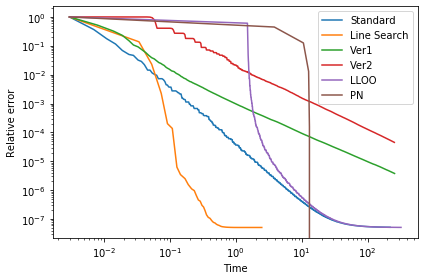

In [23]:
for data in data_list:
    min_time=10
    for policy in policy_list:
        min_time=np.minimum(min_time,np.min(time_hist_data[policy][data][1:]))
    for i in range(len(policy_list)):
        policy=policy_list[i]
        policy_label=policy_labels[i]
        series = pd.Series(error_hist_data[policy][data]) 
        plt.plot(np.cumsum(time_hist_data[policy][data])+min_time,series.cummin(), label=policy_label)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Relative error')
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.savefig(os.path.join('./pics', data + '_time.png'))
    plt.show()

In [9]:
ratio_of_iter_per_algo = {}

for data_name in data_list:
    for i in range(len(error_range)):
        iters_over_policies = [minimal_iter_per_algo[policy][data_name][i] for policy in policy_list]
        minimal_iter_val = min(iters_over_policies)
        for policy in policy_list:
            if policy not in ratio_of_iter_per_algo.keys():
                ratio_of_iter_per_algo[policy] = {}
            if data_name not in ratio_of_iter_per_algo[policy].keys():
                ratio_of_iter_per_algo[policy][data_name] = []
            ratio_of_iter_per_algo[policy][data_name].append(minimal_iter_per_algo[policy][data_name][i] / minimal_iter_val)

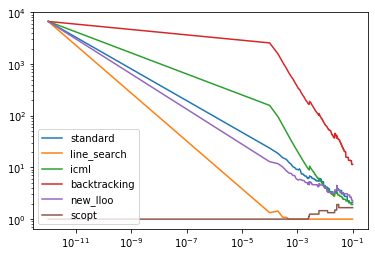

In [10]:
for policy in policy_list:
    policy_avg_ratios = []
    for i in range(len(error_range)):
        policy_avg_ratios.append(np.mean([ratio_of_iter_per_algo[policy][data_name][i] for data_name in data_list]))
    plt.plot(error_range, policy_avg_ratios, label=policy)
    plt.xscale('log')
    plt.yscale('log')
plt.legend()
plt.show()

In [11]:
problem_name = 'portfolio'
data_list = ['syn_1000_800_10_50', 'syn_1000_1200_10_50', 'syn_1000_1500_10_50']
policy_list = ["standard", "line_search", "icml"]

for data in data_list:
    with open()
    for policy in policy_list:
        file_name = os.path.join(data_folder, problem_name, data + '_' + policy + '.pckl')
        with open(file_name, 'rb') as f:
            file_data = pickle.load(f)
        for start_point in file_data:
            func_hist = start_point['Q_hist']
            time_hist = start_point['time_hist']
            plt.plot(func_hist)
            plt.xscale('log')
    plt.show()

SyntaxError: invalid syntax (<ipython-input-11-dd057a87bd49>, line 6)